<a href="https://colab.research.google.com/github/Warckor/Coursera_Capstone/blob/main/Final_Assignment/House_Sales_Analytics_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Sales in Madrid
## Final Assignment
#### Miguel Gorostola Espadiña


## Introduction 

This is a project for the Capstone in the IBM Data Science certification. In it, I must use everything studied in the previous modules to generate a notebook that analyzes a business problem or, as in this case, a business search analysis.

>### A. Business Case
>
>>I am going to carry out a market study where we can analyze the evolution of the prices of homes and premises in Madrid (Spain) by square meters. For this, we are going to include the types of businesses that are in the surroundings of the main districts of Madrid.
>>
>>This is to obtain a classification to analyze the best area, or the area of ​​greatest interest, in case a stakeholder want to open a new business looking at the price of the district premises or for the type of businesses that are around.
>>
>>Firstly, I will carry out an analysis of the evolution of the average cost per square meter of the different districts of Madrid. With this, I will be able to visualize the upward or downward projection of the cost and assess which district would be more profitable in the future to buy a local.
>>
>>Later, I would be able to analyze by district:
>>
>>*   The cheapest area to buy a place for our new business.
>>*   The types of business that we find by districts.
>>*   Where we find a greater volume of business, which implies a greater amount of market activity.
>>*   In which district we are most likely to create a business that is not in the area, so that we can take advantage of the novelty.










>### B. Data
>
>> The data used for this study will be obtained from:
>>
>>*   Statistical Center of the Community of Madrid ([Madrid City Council](https://www.madrid.es/)): Dataset of the value of the square meter of the districts of the Madrid City Council for the year 2020.
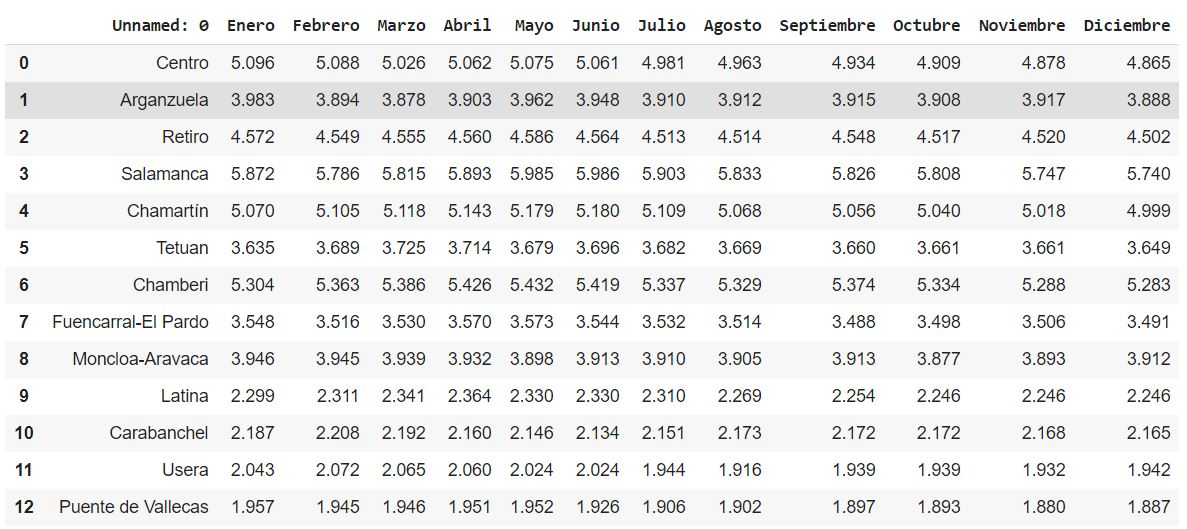
>>
>>
>>*   API Foursquare ([Foursquare](https://foursquare.com/)): I take advantage of this API to be able to obtain business from the avenues that are around the districts of Madrid, within a radius of 700 meters.
>>
>>
>>*   Using the *** geopy *** library we will use the *** Nominatim *** function to obtain the longitudes and latitudes of the districts that can be obtained with * OpenStreetMap *.



## Import Libraries

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_rent = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/Capstone IBM/Houses_Price.xlsx")
df_rent.head()

,Unnamed: 0,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,Centro,5096,5088,5026,5062,5075,5061,4981,4963,4934,4909,4878,4865
1,Arganzuela,3983,3894,3878,3903,3962,3948,3910,3912,3915,3908,3917,3888
2,Retiro,4572,4549,4555,4560,4586,4564,4513,4514,4548,4517,4520,4502
3,Salamanca,5872,5786,5815,5893,5985,5986,5903,5833,5826,5808,5747,5740
4,Chamartín,5070,5105,5118,5143,5179,5180,5109,5068,5056,5040,5018,4999


In [5]:
cols = df_rent.drop('Unnamed: 0', axis=1)
cols = cols.columns.values
cols

array(['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio',
       'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'],
      dtype=object)

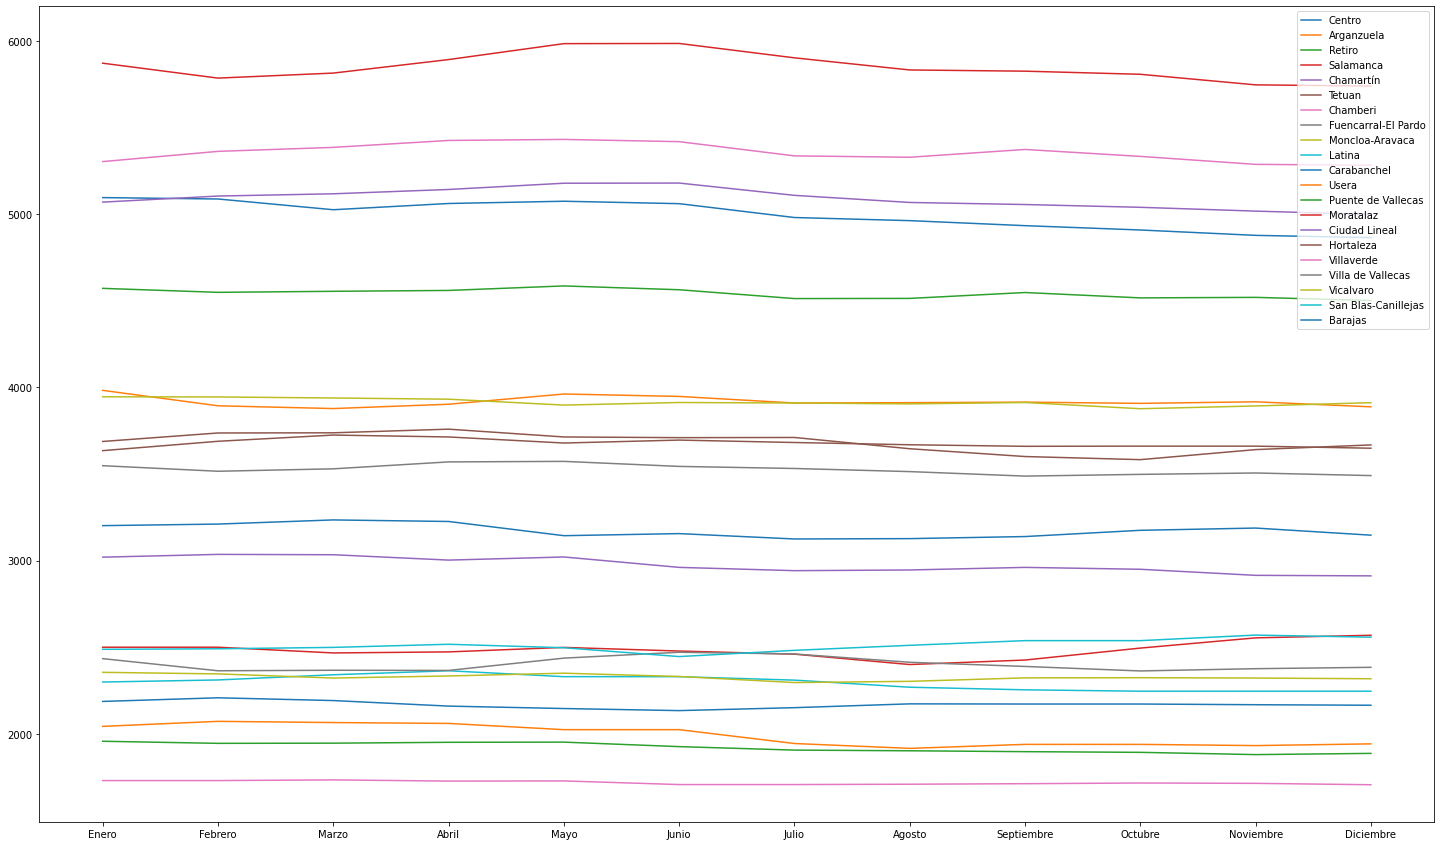

In [16]:
plt.figure(figsize=(25,15))

df_month = df_rent[cols].T

plt.plot(df_month)
plt.legend(df_rent["Unnamed: 0"])
plt.show()

En la mayoría de distritos no vemos una desviación importante o llamativa en el coste por metro cuadrado, por lo que para analizar los datos voy a coger los del último mes